In [34]:
!pip install transformers
!pip install tqdm

# 0. Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# torch and transformers
import torch
from torch import cuda
import transformers
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

#import different metrics to evaluate the classifiers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score

from tqdm import tqdm

import itertools
import re

# 1. Utils

Funciones de utilidad o ayuda que se utilizaran para limpiar y preprocesar el texto y la evaluación del modelo.

In [36]:
################################
# text processing and cleaning #
################################

def encode_sentiment(sentiment):
  if sentiment == "positive":
    return 1
  else:
    return 0

def is_ascii(w):
  try:
    w.encode("ascii")
    return True
  except UnicodeEncodeError:
    return False

def text_cleaning(text):
  """
  Clean text from symbols, punctuation, etc.

  Parameters:
  -----------
  text: string, text data
  
  Returns:
  --------
  cleaned_text: string, cleaned text data
  """
  # remove string formatting '\n' or '\t'
  tmp_text = re.sub(r'\n+', '. ', text)
  tmp_text = re.sub(r'\t+', '. ', tmp_text)
  # remove words with non-ascii characters
  tmp_text = " ".join([word for word in tmp_text.split() if is_ascii(word)])
  # remove email address
  tmp_text = " ".join([word for word in tmp_text.split() if not word.startswith("@")])
  # remove urls
  tmp_text = re.sub(r'http\S+', '', tmp_text, flags=re.MULTILINE)
  tmp_text = re.sub(r'www\S+', '', tmp_text, flags=re.MULTILINE)
  # remove punctuation but . (to split sentences)
  cleaned_text = re.sub('[^A-Za-z.,]+', ' ', tmp_text)
  # lowercase
  cleaned_text = cleaned_text.lower()

  return cleaned_text

##############
# Evaluation #
##############

def plot_learning(train_loss, val_loss, val_acc, EPOCHS):
    """Plot training history.

    Plot 1: Loss / epochs
    Plot 2: Val_Acc / epochs

    Parameters:
    ___________

    train_loss, val_loss, val_acc: Lists
    EPOCHS: int
    ___________

    Returns: None
    """

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 7))
    plt.plot(epochs, train_loss, 'b',c="blue", label='Training loss')
    plt.plot(epochs, val_loss, 'b',c="orange", label='Validation loss')
    plt.xticks(ticks=[epoch for epoch in range(1, EPOCHS+1)])
    plt.title('Training and validation loss')
    plt.xlabel("# Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.figure(figsize=(14, 7))
    plt.plot(epochs, val_acc, 'b',c="orange", label='Validation acc')
    plt.xticks(ticks=[epoch for epoch in range(1, EPOCHS+1)])
    plt.title('Validation acc')
    plt.xlabel("# Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show();

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# 2. Config

In [37]:
# path to save model
MODEL_PATH = '/content/drive/My Drive/MasterIADeporte/Modulo6_BERT/imdb_bert_fine_tuned.bin'

# Defining some key variables that will be used later on in the training
MAX_LEN = 252
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
EPOCHS = 2
SEED = 42
# BERT tokenizer
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')

# Setting up the device for GPU usage
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# 3. Data

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.

In [38]:
# sampled 25000 from the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
raw_data = pd.read_csv('/content/drive/My Drive/MasterIADeporte/Modulo6_BERT/IMDB_Dataset.csv', encoding='utf-8').sample(frac=0.5, random_state=SEED)
raw_data.head()

Mounted at /content/drive


,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


In [39]:
print(f"Number of reviews: {raw_data.shape[0]}")

Number of reviews: 25000


In [40]:
# encode sentiment for training
raw_data['sentiment'] = raw_data['sentiment'].map(encode_sentiment)
raw_data.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,1
9427,Not many television shows appeal to quite as m...,1
199,The film quickly gets to a major chase scene w...,0
12447,Jane Austen would definitely approve of this o...,1
39489,Expectations were somewhat high for me when I ...,0


In [41]:
for idx in range(4):
  print(f"Review: {raw_data.iloc[idx, 0]}")

Review: I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defe

## 3.1. Train / Validation / Test Splits

In [42]:
train, val = train_test_split(raw_data, test_size=0.12, stratify=raw_data.sentiment)
train, test = train_test_split(train, test_size=0.12, stratify=train.sentiment)
# reset index
train = train.reset_index()
val = val.reset_index()
test = test.reset_index()

In [43]:
print("TRAIN Dataset: {}".format(train.shape))
print("VAL Dataset: {}".format(val.shape))
print("TEST Dataset: {}".format(test.shape))

TRAIN Dataset: (19360, 3)
VAL Dataset: (3000, 3)
TEST Dataset: (2640, 3)


In [44]:
print(train.sentiment.value_counts())
print(val.sentiment.value_counts())
print(test.sentiment.value_counts())

1    9693
0    9667
Name: sentiment, dtype: int64
1    1502
0    1498
Name: sentiment, dtype: int64
1    1322
0    1318
Name: sentiment, dtype: int64


# 4. Dataset and Dataloader

La clase BertDataset crea un dataset de Pytorch del tipo map-iterable y preprocesa el texto de acuerdo a los requerimientos del modelo BERT.

DataLoader de Pytorch toma la clase Dataset para poder pasar ejemplos al modelo en lotes o batches.


In [45]:
class BertDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = str(self.data['review'].loc[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.data['sentiment'].loc[index], dtype=torch.float)
        }

    def __len__(self):
        return self.len

In [46]:
# text cleaning
train["review"] = train["review"].map(text_cleaning)
val["review"] = val["review"].map(text_cleaning)
test["review"] = test["review"].map(text_cleaning)

In [47]:
# create Pytorch datasets
training_set = BertDataset(train, TOKENIZER, MAX_LEN)
validation_set = BertDataset(val, TOKENIZER, MAX_LEN)
test_set = BertDataset(test, TOKENIZER, MAX_LEN)

In [48]:
print("---- Visually inspecting 5th element ----")
print(f"Input ids: {training_set[6]['ids']}")
print(f"Attention masks: {training_set[6]['mask']}")
print(f"Token type ids: {training_set[6]['token_type_ids']}")
print(f"Target: {training_set[6]['targets']}")
print("------------------------------------------")

---- Visually inspecting 5th element ----
Input ids: tensor([  101,  2257,  2223,  1997,  9313, 11218,  7987,  7987,  5977, 17639,
         2100,  2003,  2028,  1997,  1996,  2035,  2051,  2307,  2015,  1998,
         1045,  2031,  2042,  1037,  5470,  1997,  2010,  2144,  1996,  1055,
         1012,  1045,  2253,  2000,  2023,  3185,  2138,  5977, 17639,  2100,
         2001,  1996,  2364,  3364,  1012,  1045,  2018,  2025,  3191,  4391,
         2030,  2018,  2151,  3188,  3716,  1997,  1996,  3185,  1012,  1996,
         3185,  4527,  2033,  3243,  1037,  2978,  1012,  1996, 17363,  1998,
        15925,  2020, 12656,  1010,  2021,  1996,  5436,  2001,  4895, 22852,
         2000,  1996,  2391,  1997,  2108,  9951,  1012,  1999,  2026,  2568,
         2023,  2001,  2025,  2028,  1997,  2010,  2488,  5691,  2009,  2071,
         2022,  1996,  5409,  1012,  2339,  2002,  4900,  2000,  2022,  1999,
         2023,  3185,  2003,  1037,  6547,  1012,  2005,  2033,  1010,  2183,
         20

In [49]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VAL_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

train_data_loader = DataLoader(training_set, **train_params)
val_data_loader = DataLoader(validation_set, **val_params)
test_data_loader = DataLoader(test_set, **test_params)

# 5. Creating the NN for fine tuning

#### Neural Network
 - We will be creating a neural network with the `BERTClass`. 
 - This network will have the BERT Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs. 
 - The data will be fed to the BERT Language model as defined in the dataset. 
 - Final layer outputs is what will be compared to the `encoded category` to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - `Loss Function` and `Optimizer` and defined in the next cell.
 - The `Loss Function` is used the calculate the difference in the output created by the model and the actual output. 
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [50]:
# Creating the customized model, by adding a drop out and a dense layer on top of distilbert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(768, 1) # Binary classification. Criteria > 0.5

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
            )
        bert_outputs = output_1[0]
        x = bert_outputs[:, 0]  # CLS token
        x = self.pre_classifier(x)
        x = torch.nn.ReLU()(x)
        x = self.dropout(x)
        output = self.classifier(x)
        return output

# 6. Train and Evaluation

In [51]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))


def train_fn(data_loader, model, optimizer, device):
    model.train()
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d['ids']
        mask = d['mask']
        token_type_ids = d["token_type_ids"]
        targets = d['targets']

        # send them to device
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
            )

        # calculate loss
        loss = loss_fn(outputs, targets)
        # backpropagation
        loss.backward()
        optimizer.step()
    
    return loss

def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            token_type_ids = d["token_type_ids"]
            targets = d['targets']

            # send them to the cuda device we are using
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                token_type_ids=token_type_ids
            )
            val_loss = loss_fn(outputs, targets)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets, val_loss

# 6. Fine Tuning the Model



In [52]:
def fit():
    model = BERTClass()
    param_optimizer = list(model.named_parameters())

    device = DEVICE
    model.to(DEVICE)

    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_parameters, lr=3e-5)  # to minimize loss function

    train_loss = []
    val_loss = []
    val_acc = []
    val_f_scores = []
    best_accuracy = 0
    for i, epoch in enumerate(range(EPOCHS)):
        print(f"Epoch {i + 1}.")
        train_loss_epoch = train_fn(train_data_loader, model, optimizer, device)
        outputs, targets, val_loss_epoch = eval_fn(val_data_loader, model, device)
        train_loss.append(train_loss_epoch)
        val_loss.append(val_loss_epoch)
        outputs = np.array(outputs) >= 0.5
        accuracy = accuracy_score(targets, outputs)
        f_score = f1_score(targets, outputs)
        val_acc.append(accuracy)
        val_f_scores.append(f_score)
        print(f"Validation Accuracy Score = {accuracy}")
        print(f"Validation F1-Score = {f_score}")
        # save best model
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), MODEL_PATH)
            best_accuracy = accuracy

    return train_loss, val_loss, val_acc

In [53]:
train_loss, val_loss, val_acc = fit()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1.


100%|██████████| 47/47 [01:46<00:00,  2.26s/it]


Validation Accuracy Score = 0.9126666666666666
Validation F1-Score = 0.9148244473342002
Epoch 2.


100%|██████████| 47/47 [01:47<00:00,  2.29s/it]


Validation Accuracy Score = 0.915
Validation F1-Score = 0.9170731707317074


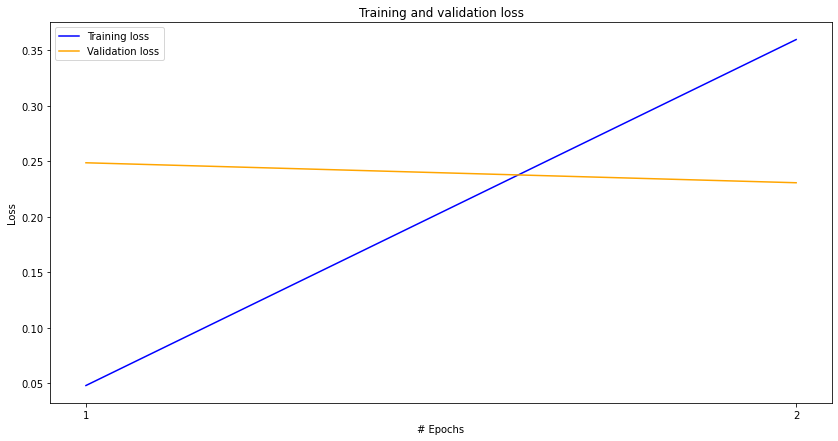

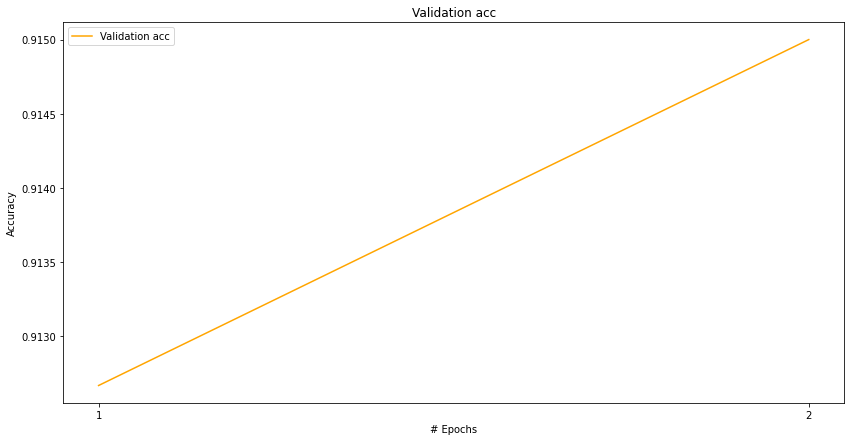

In [54]:
plot_learning(train_loss, val_loss, val_acc, EPOCHS)

# 7. Evaluation on Training set and Validation set

In [55]:
# load best model
best_model = BERTClass()
best_model.load_state_dict(torch.load(MODEL_PATH))
best_model.to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [56]:
def predict_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            token_type_ids = d["token_type_ids"]
            targets = d['targets']

            # send them to the cuda device we are using
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                token_type_ids=token_type_ids
            )
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

**TRAINING**

In [57]:
train_outputs, train_targets = predict_fn(
    train_data_loader,
    model=best_model,
    device=DEVICE
)

100%|██████████| 1210/1210 [11:50<00:00,  1.70it/s]


In [58]:
train_outputs = np.array(train_outputs) >= 0.5

In [59]:
accuracy = accuracy_score(train_targets, train_outputs)
f_score = f1_score(train_targets, train_outputs)
print(f"Training Accuracy Score = {accuracy}")
print(f"Training F1-Score = {f_score}")

Training Accuracy Score = 0.9851239669421488
Training F1-Score = 0.9852428776388604


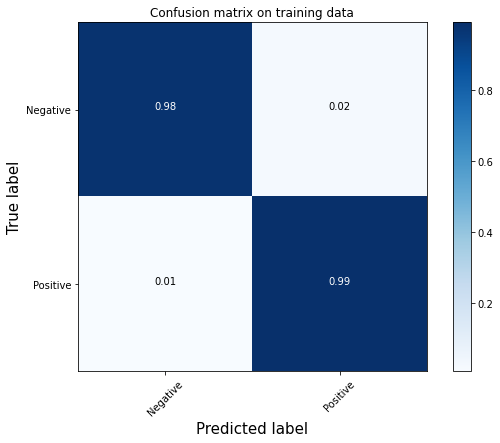

In [60]:
# print the confusion matrix
cnf_matrix = confusion_matrix(train_targets, train_outputs, labels=[0, 1])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,
    classes=['Negative','Positive'],
    normalize=True,
    title='Confusion matrix on training data'
)

**VALIDATION**

In [61]:
val_outputs, val_targets = predict_fn(
    val_data_loader,
    model=best_model,
    device=DEVICE
)

100%|██████████| 47/47 [01:47<00:00,  2.29s/it]


In [62]:
val_outputs = np.array(val_outputs) >= 0.5

In [63]:
accuracy = accuracy_score(val_targets, val_outputs)
f_score = f1_score(val_targets, val_outputs)
print(f"Val Accuracy Score = {accuracy}")
print(f"Val F1-Score = {f_score}")

Val Accuracy Score = 0.915
Val F1-Score = 0.9170731707317074


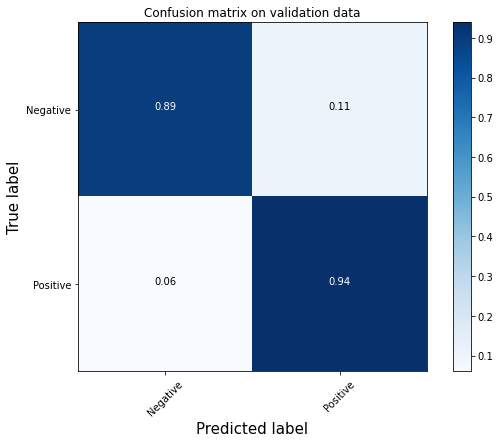

In [64]:
# print the confusion matrix
cnf_matrix = confusion_matrix(val_targets, val_outputs, labels=[0, 1])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,classes=['Negative','Positive'],
    normalize=True,
    title='Confusion matrix on validation data'
)

**TEST**

100%|██████████| 42/42 [01:34<00:00,  2.24s/it]


Test Accuracy Score = 0.9147727272727273
Test F1-Score = 0.9165120593692022


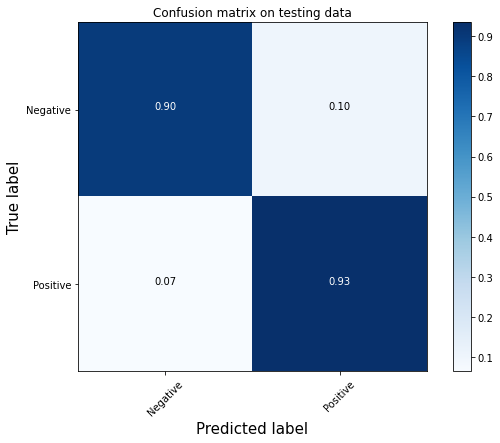

In [65]:
test_outputs, test_targets = predict_fn(
    test_data_loader,
    model=best_model,
    device=DEVICE
)

test_outputs = np.array(test_outputs) >= 0.5

accuracy = accuracy_score(test_targets, test_outputs)
f_score = f1_score(test_targets, test_outputs)
print(f"Test Accuracy Score = {accuracy}")
print(f"Test F1-Score = {f_score}")

# print the confusion matrix
cnf_matrix = confusion_matrix(test_targets, test_outputs, labels=[0, 1])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,
    classes=['Negative','Positive'],
    normalize=True,
    title='Confusion matrix on testing data'
)

In [66]:
for review, target, prediction in zip(test.review.values.tolist(), test_targets, test_outputs):
  print(f"Review: {review}")
  print(f"Target: {target}\tPrediction: {prediction}")
  print("-"*30)

Se han truncado las últimas 5000 líneas del flujo de salida.
Review: god, i was bored out of my head as i watched this pilot. i had been expecting a lot from it, as i m a huge fan of james cameron and not just since titanic , i might add , and his name in the credits i thought would be a guarantee of quality then again, he also wrote the leaden strange days.. . but the thing failed miserably at grabbing my attention at any point of its almost two hours of duration. in all that time, it barely went beyond its two line synopsis, and i would be very hard pressed to try to figure out any kind of coherent plot out of all the mess of strands that went nowhere. on top of that, i don t think the acrobatics outdid even those of any regular a team episode. as for alba, yes, she is gorgeous, of course, but the fact that she only displays one single facial expression the entire movie pouty and surly , makes me also get bored of her gal wit an attitude schtick pretty soon. you can count me out of t

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

